This program calculates the density fluctuation based on the improvement of *Miyatomo et al. (2014)*.

The improvement we made is taking advantage of the actual velocity of density fluctuations obtained by multi-baseline method. 

In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyleoclim as pyleo

from frequency_analyse_utils import convert_to_second_of_day, convert_to_HHMM, \
    eliminate_outliers, interpolate, detrend
    
%matplotlib widget

First, we need to import the imformation of multi-baseline cases obtained before. 

The parameter *'calc_f_prime_method'* defines the method to calculate the frequency fluctuation, $f'$.

(1) If the parameter is set as *'peak'*, the method from *Miyamoto et al. (2014)* is used; 

(2) If the parameter is set as *'integral'*, the integral method is used. 

In [ ]:
## Importing data
i_case = 5
calc_f_prime_method = 'integral' # 'peak' or 'integral'
if i_case == 1: # 2021/10/01(274), 04:40-07:20, sh-km, sh-Ks, km-Ks
    file_dir = 'E:/Research/Data/Tianwen-1/m1a01x_up/'
    save_dir = 'E:/Research/Work/tianwen_IPS/m1a01x_up/'
    file_sh = 'shshchan3frephase1s.dat' # 04:40-08:00, 1s
    file_km = 'kmkmchan3frephase1s.dat' # 04:40-08:00, 1s
    file_Ks = 'KSfreq.dat'              # 06:58-09:00, 1s
    file_name = file_Ks
    time_beg = 2021274070000
    time_end = 2021274073000
    fluc_beg = 2021274071000
    fluc_end = 2021274071600
    Tc = 250
    Tl, Tu = 200, 300
    rs = 8.98
    vp = 85.77
elif i_case == 2: # 2021/10/01(274), 04:40-07:20, sh-km, sh-Ks, km-Ks
    file_dir = 'E:/Research/Data/Tianwen-1/m1a01x_up/'
    save_dir = 'E:/Research/Work/tianwen_IPS/m1a01x_up/'
    file_sh = 'shshchan3frephase1s.dat' # 04:40-08:00, 1s
    file_km = 'kmkmchan3frephase1s.dat' # 04:40-08:00, 1s
    file_Ks = 'KSfreq.dat'              # 06:58-09:00, 1s
    file_name = file_Ks
    time_beg = 2021274071500
    time_end = 2021274074500
    fluc_beg = 2021274072800
    fluc_end = 2021274073000
    Tc = 250
    Tl, Tu = 200, 300
    rs = 8.98
    vp = 136.29
elif i_case == 3: # 2021/10/12(285), 09:50-11:00, Ht-Wz, Ht-Ys, Wz-Ys
    file_dir = 'E:/Research/Data/Tianwen-1/m1a12x/'
    save_dir = 'E:/Research/Work/tianwen_IPS/m1a12x/'
    file_Ht = 'HtHtchan3_1frephase1s.dat' # 09:50-11:00, 1s
    file_Wz = 'WzWzchan3_1frephase1s.dat' # 09:50-14:00, 1s
    file_Ys = 'YsYschan3_1frephase1s.dat' # 09:50-11:00, 1s
    file_name = file_Ys
    time_beg = 2021285094500
    time_end = 2021285101500
    fluc_beg = 2021285095500
    fluc_end = 2021285095700
    Tc = 110
    Tl, Tu = 85, 140
    rs = 5.72
    vp = 161.55
elif i_case == 4: # 2021/10/23(296), 03:30-06:30, sh-km, sh-ur, km-ur
    file_dir = 'E:/Research/Data/Tianwen-1/m1a23x/'
    save_dir = 'E:/Research/Work/tianwen_IPS/m1a23x/'
    file_sh = 'shshchan5_1frephase1s.dat' # 03:42-06:30, 1s
    file_km = 'kmkmchan5_1frephase1s.dat' # 03:43-06:30, 1s
    file_ur = 'ururchan5_1frephase1s.dat' # 03:45-06:30, 1s
    file_name = file_ur
    time_beg = 2021296043000
    time_end = 2021296050000
    fluc_beg = 2021296044500
    fluc_end = 2021285044800
    Tc = 350
    Tl, Tu = 300, 400
    rs = 18.6
    vp = 90.82
elif i_case == 5: # 2021/10/23(296), 03:30-06:30, sh-km, sh-ur, km-ur
    file_dir = 'E:/Research/Data/Tianwen-1/m1a23x/'
    save_dir = 'E:/Research/Work/tianwen_IPS/m1a23x/'
    file_sh = 'shshchan5_1frephase1s.dat' # 03:42-06:30, 1s
    file_km = 'kmkmchan5_1frephase1s.dat' # 03:43-06:30, 1s
    file_ur = 'ururchan5_1frephase1s.dat' # 03:45-06:30, 1s
    file_name = file_ur
    time_beg = 2021296054500
    time_end = 2021296061500
    fluc_beg = 2021296060400
    fluc_end = 2021296060600
    Tc = 70
    Tl, Tu = 60, 80
    rs = 18.6
    vp = 141.34

## Converting subplot time interval
str_beg = str(time_beg)[-6:-2]
str_end = str(time_end)[-6:-2]
sod_beg = convert_to_second_of_day(time_beg)[0]
sod_end = convert_to_second_of_day(time_end)[0]
sod_fluc_beg = convert_to_second_of_day(fluc_beg)[0]
sod_fluc_end = convert_to_second_of_day(fluc_end)[0]
    
## Reading data
file_path = file_dir + file_name
data = np.loadtxt(file_path)

## Extrcating data
time = data[:, 0]
sod = convert_to_second_of_day(time)
if file_name == 'KSfreq.dat':
    sod = time # time has been formatted as 'sod'
freq = data[:,1]

## Selecting time interval
ind_sub = np.where((sod > sod_beg) & (sod < sod_end))
sod_sub, freq_sub = sod[ind_sub], freq[ind_sub]

In [357]:
## Preprocessing frequency series
# step 1: eliminate outliers
freq_out, sod_out = eliminate_outliers(freq_sub, sod_sub, 10)
# step 2: detrend for frequency sequence
if file_name == 'KSfreq.dat':
    freq_fit, freq_detrend = detrend(freq_out, sod_out, 5) #3,5,7,9,11
else:
    freq_fit, freq_detrend = detrend(freq_out, sod_out, 3) #3,5,7,9,11
# step 3: interpolation for frequency sequence
freq_interp = interpolate(freq_detrend, sod_out, sod_sub)

In [358]:
## Constructing pyleo.series         
series = pyleo.Series(time=sod_sub, value=freq_interp, \
    time_name='Time', time_unit='seconds', value_name = 'Freq', value_unit='Hzs', label=file_name[0:2])

## lowpass filter cutoff at 0.1 Hz
series = series.interp().filter(cutoff_freq=0.1)
freq_interp = series.value

Time axis values sorted in ascending order


The calculation of density fluctuation includes the following five steps: 

1. Plot the wavelet spectrum of the signal to determine the time interval of interest. 

The time interval of interest should include and be limited to a steady peak in the wavelet spectrum. 

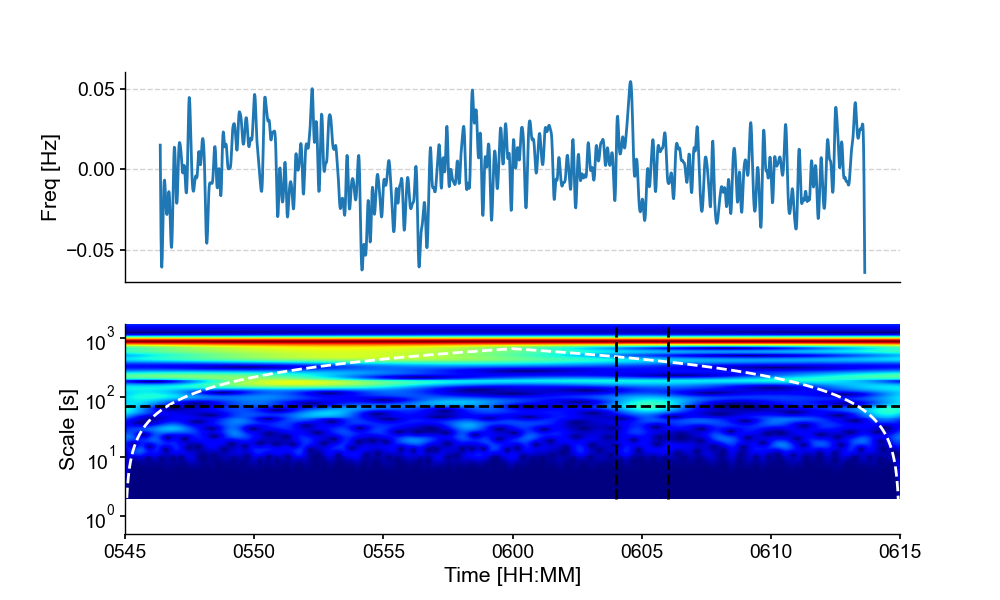

In [359]:
## Plotting the wavelet spectrum
cwt = series.wavelet(method='cwt')

plt.figure(figsize=(10,6))

plt.subplot(211)
plt.plot(cwt.time, freq_interp)
plt.xticks([])
plt.ylabel('Freq [Hz]')

plt.subplot(212)
plt.pcolormesh(cwt.time, cwt.scale[-1::-1], np.rot90(cwt.amplitude), cmap='jet')
plt.plot(cwt.time, cwt.coi, 'w--')
plt.hlines(y=Tc, linestyles='--', color='k', xmin=min(cwt.time), xmax=max(cwt.time))
plt.vlines(x=sod_fluc_beg, linestyles='--', color='k', ymin=min(cwt.scale), ymax=max(cwt.scale))
plt.vlines(x=sod_fluc_end, linestyles='--', color='k', ymin=min(cwt.scale), ymax=max(cwt.scale))
plt.yscale('log')
plt.xlabel('Time [HH:MM]')
plt.ylabel('Scale [s]')

xposs = [0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]
xticks = [int(xpos*(sod_end-sod_beg)+sod_beg) for xpos in xposs]
xlabels = [convert_to_HHMM(xtick) for xtick in xticks]
plt.xticks(xticks, labels=xlabels)

plt.show()

In [360]:
## Selecting the time interval of interest
ind_fluc_sub = np.where((sod_sub > sod_fluc_beg) & (sod_sub < sod_fluc_end))
sod_fluc_sub, freq_fluc_sub = sod_sub[ind_fluc_sub], freq_interp[ind_fluc_sub]

## Constructing pyleo.series of interest
series_fluc = pyleo.Series(time=sod_fluc_sub, value=freq_fluc_sub, \
    time_name='Time', time_unit='seconds', value_name = 'Freq', value_unit='Hzs', label=file_name[0:2]+'-fluc')

Time axis values sorted in ascending order


2. Calculate the amplitude of the frequency fluctuation, $f'$, from the power spectrum averaged in the time interval of interest. 

There are two methods for the calculation of frequency fluctuation, please select method (2) only when method (1) is not available. 

(1) The method from *Miyamoto et al. (2014)*: 

$$f'=\sqrt{2PB}$$

- $P$ is the peak spectral density; 
- $B$ is the full-width-half-magnitude (FWHM) of the peak. 

(2) The integral method for **two-sided** power spectrum is:

$$f'=\sqrt{4 \times \int_{f_l}^{f_u}{PSD(f){\rm d}f}}=2 \times \sqrt{\int_{f_l}^{f_u}{PSD(f){\rm d}f}}$$

- $PSD(f)$ is the power spectral density;
- $(f_l, f_u)$ is the lower and upper limit of the frequency range. 

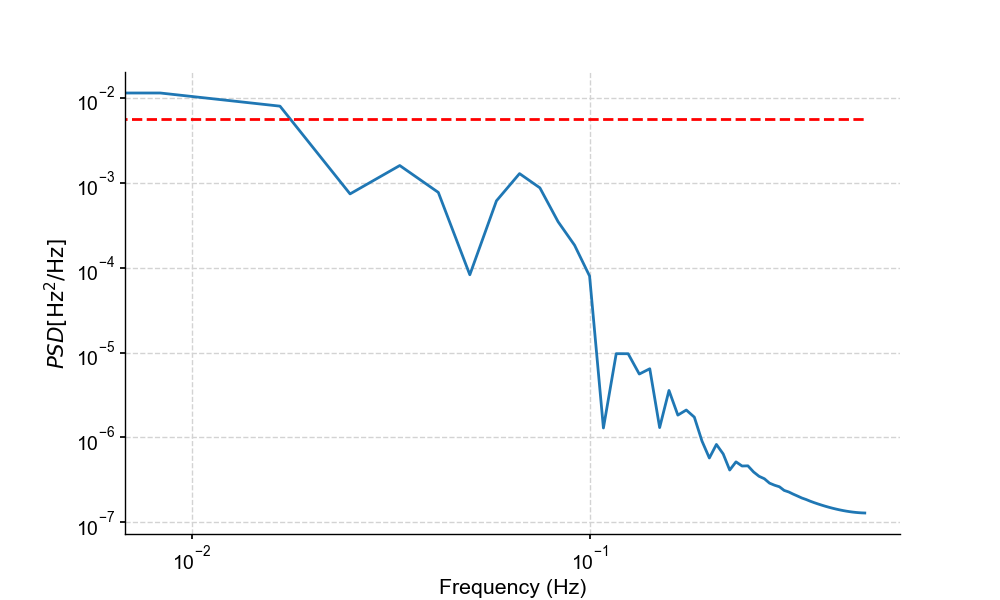

In [361]:
## Calculating power spectral density
def calc_psd(time, signal):
    '''
    This function is used to calculate the Power Spectral Density
    '''
    n = len(signal)
    fourier_transform = np.fft.fft(signal)
    psd = (1 / n) * np.abs(fourier_transform) ** 2
    frequencies = np.fft.fftfreq(n, time[1] - time[0])
    positive_freq_indices = frequencies >= 0
    frequencies = frequencies[positive_freq_indices]
    psd = psd[positive_freq_indices]

    return frequencies, psd

freq_psd, psd = calc_psd(sod_fluc_sub, freq_fluc_sub)

plt.figure(figsize=(10, 6))

plt.plot(freq_psd, psd)
plt.hlines(y=max(psd[1:-1]) / 2, linestyles='--', colors='r', xmin=min(freq_psd), xmax=max(freq_psd))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$PSD [{\rm Hz^2/Hz}]$')
plt.show()

In [ ]:
## Calculating the amplitude of the frequency fluctuation
if calc_f_prime_method == 'peak':
    P_psd = 1.38 # Hz
    B_psd_min, B_psd_max = 0.0083, 0.019 # [Hz]
    f_psd = 0.0167 # [Hz]
    T_psd = 1 / f_psd # [s]
    B_psd = B_psd_max - B_psd_min
    
    f_prime = np.sqrt(2 * P_psd * B_psd)
    
elif calc_f_prime_method == 'integral': 
    fl_psd, fu_psd = 1 / Tu, 1 / Tl
    
    def interp_int_boundary(x, x_data, y_data):
        idx = np.searchsorted(x_data, x)
        x0, x1 = x_data[idx-1], x_data[idx]
        y0, y1 = y_data[idx-1], y_data[idx]
        return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
    
    psd_fl = interp_int_boundary(fl_psd, freq_psd, psd)
    psd_fu = interp_int_boundary(fu_psd, freq_psd, psd)
    
    mask_ind = (freq_psd >= fl_psd) & (freq_psd <= fu_psd)
    freq_filter = freq_psd[mask_ind]
    psd_filter = psd[mask_ind]
    
    freq_int_sub = np.concatenate([[fl_psd], freq_filter, [fu_psd]])
    psd_int_sub = np.concatenate([[psd_fl], psd_filter, [psd_fu]])
    
    psd_int = np.trapz(psd_int_sub, freq_int_sub)
    f_prime = 2 * np.sqrt(psd_int)

print(f_prime)

0.0120932342001828


3. Calculate the fluctuation of Slant Total Electron Contents (STEC), $n'$, based on $f'$ above:

$$N'=\frac{cfT}{2\pi \alpha}f'$$

- $c$ is the speed of light, $c=3\times 10^8 {\rm m/s}$; 
- $f$ is the frequency of the radio wave, $f=8.4 {\rm GHz}$; 
- $T$ is the period of the oscillating component, corresponding to the period of the peak spectral density; 
- $\alpha$ is a constant, $\alpha=\frac{e^2}{8\pi^2 \varepsilon_0 m_e}=40.3 {\rm m^3 s^{-2}}$

In [363]:
## Calculating the fluctuation of STEC
c0 = 3e8 # [m/s]
f0 = 8.4e9 # [Hz]
alpha = 40.3 # [m3/s2]
T_psd = Tc

N_prime = c0 * f0 * T_psd / 2 / np.pi / alpha * f_prime # [m-2]


4. Calculate the amplitude of density fluctuation, $n'$, under the assumption that the slant length of the density fluctuation is equal to the length of the wave packet, and $n'$ is uniform within this range: 

$$n'=\frac{N'}{L}=\frac{N'}{v_p T}$$

- $v_p$ is the propagation speed obtained from the multi-baseline measurement. 

In [364]:
## Calculating the amplitude of density fluctuation
n_prime = N_prime / (vp * 1e3) / T_psd # [m-3]
n_prime_cm = n_prime * 1e-6 # [cm-3]

5. Calculate the relative density fluctuation, where the background electron density, $n_0$, is given by the empirical model proposed by *Paetzold et al. (1987)*:

$$n_0(r)=\left( \frac{5.79}{r^{16}} + \frac{1.6}{r^6} + \frac{0.0092}{r^2} \right) \times 10^8 {\rm cm^{-3}}$$

In [365]:
## Calculating the relative density fluctuaion
n0_cm = (5.79 / rs**16 + 1.6 / rs**6 + 0.0092 / rs**2) * 1e8 # [cm-3]

npn0 = n_prime_cm / n0_cm

Print results

In [366]:
print('f_prime[Hz]: ', f_prime)
print('N_prime[m-2]:', N_prime)
print('n_prime[cm-3]: ', n_prime_cm)
print('n0[cm-3]: ', n0_cm)
print('n_prime/n0: ', npn0)

f_prime[Hz]:  0.0120932342001828
N_prime[m-2]: 8424732688921407.0
n_prime[cm-3]:  851.5163727709684
n0[cm-3]:  2663.131013541601
n_prime/n0:  0.3197425768545152
